# Corn Job Executable 

## Imports 

In [1]:
import sys
import os
sys.path.append("../")
sys.path.append("../FinRL/")

import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import pickle
import pandas as pd
import datetime
import numpy as np
import threading
import time
from stockstats import StockDataFrame as Sdf
from sklearn.preprocessing import StandardScaler
from finrl.meta.preprocessor.preprocessors import data_split

from Config.alpacha_config import API_KEY, API_SECRET, API_BASE_URL
from Config.local_config import DOW_30_TICKERS
from Config.local_config import PCA_INDICATORS

from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3 import SAC

d:\University\Thesis\env-FinRL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from finrl.agents.stablebaselines3.models import DRLAgent
from copy import deepcopy
from contextlib import contextmanager
from finrl.plot import get_daily_return
import empyrical
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
import Config.model_kwargs_config as model_kwargs

## Finding The Best Model

#### Other Functions 

In [ ]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
class model_parameters:
    def __init__(self, model_name, kwargs, steps, data, data_retention_level):
        self.model_name = model_name
        self.model = None
        self.sharpe = []
        self.kwargs = kwargs
        self.policy = "MlpPolicy"
        self.policy_kwargs = None
        self.verbose = 0
        self.total_timesteps = steps
        self.data = data
        self.data_retention_level = data_retention_level

In [ ]:
class account_training:
    def __init__(self, balance, stock_dimension, turbulence_threshold, stocks_held = None):
        self.balance = balance
        self.hmax = 100
        self.buy_cost = 0.001
        self.sell_cost = 0.001
        self.stock_dimension = stock_dimension
        self.turbulence_threshold = turbulence_threshold
        if stocks_held == None:
            self.num_of_stocks = [0] * stock_dimension
        else:
            self.num_of_stocks = stocks_held

#### Regime Switching System For Getting The Current Best Model

In [ ]:
class val_current():
    def __init__(self, models, window):
        self.models = models
        self.window = window

        self.unique_trade_date = models[0].data.date.unique()

        self.account = account_training(100000, 29, 30)

        for mod in self.models:
            training_env, e_val_gym = self.create_environments(mod.data)
            print(f"Training {mod.model_name}_{mod.data_retention_level}")
            mod.model = self.train(training_env, mod)
            mod.sharpe.append(self.val(e_val_gym, mod.model))
        
        self.best_model, self.best_model_name = self.get_best_model()

    
    def train(self, env, mod):
        with suppress_stdout():
            agent = DRLAgent(env = env)
            kwargs = deepcopy(mod.kwargs)
            model = agent.get_model(
                mod.model_name,
                policy = mod.policy,
                policy_kwargs = mod.policy_kwargs,
                model_kwargs = kwargs
            )
            trained_model = agent.train_model(model = model, tb_log_name = mod.model_name, total_timesteps = mod.total_timesteps)

        return trained_model

    
    def val(self, env, model):
        with suppress_stdout():
            df_account_value, df_actions, _ = DRLAgent.DRL_prediction(
                model = model, 
                environment = env
            )

        df = deepcopy(df_account_value)
        df["date"] = pd.to_datetime(df["date"])
        bt_returns = get_daily_return(df, value_col_name="account_value")

        return empyrical.sharpe_ratio(bt_returns)

    def get_best_model(self):
        best_model_sharpe = float('-inf')
        for model in self.models:
            if model.sharpe[-1] > best_model_sharpe:
                best_model_sharpe = model.sharpe[-1]
                best_model = model
                best_model_name = model.model_name
        
        return best_model, best_model_name
    
    def create_environments(self, data):
        train_data = data_split(
            data, 
            start = data['date'][0],
            end = self.unique_trade_date[(len(self.unique_trade_date) - self.window)]
        )
        val_data = data_split(
            data,
            start = self.unique_trade_date[(len(self.unique_trade_date) - self.window)],
            end = self.unique_trade_date[-1],
        )
        
        kwargs = {
            'hmax': self.account.hmax,
            "initial_amount": self.account.balance,
            "num_stock_shares": self.account.num_of_stocks,
            "buy_cost_pct": [self.account.buy_cost] * self.account.stock_dimension,
            "sell_cost_pct": [self.account.sell_cost] * self.account.stock_dimension,
            "state_space": 1 + 2 * self.account.stock_dimension + len(val_data.columns[7:-2]) * self.account.stock_dimension,
            "stock_dim": self.account.stock_dimension,
            "tech_indicator_list": val_data.columns[7:-2],
            "action_space": self.account.stock_dimension,
            "reward_scaling": 1e-4
        }

        e_train_gym = StockTradingEnv(df = train_data, **kwargs)
        e_val_gym = StockTradingEnv(df = val_data, turbulence_threshold = self.account.turbulence_threshold, risk_indicator_col='vix', **kwargs)
        
        training_env, _ = e_train_gym.get_sb_env()

        return training_env, e_val_gym
    

In [ ]:
data_85 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.85_current.csv", index_col=0)
data_99 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.99_current.csv", index_col=0)

a2c_85 = model_parameters(model_name="a2c", kwargs=deepcopy(model_kwargs.A2C_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["a2c"], data = data_85, data_retention_level = "85")
a2c_99 = model_parameters(model_name="a2c", kwargs=deepcopy(model_kwargs.A2C_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["a2c"], data = data_99, data_retention_level = "99")

ddpg_85 = model_parameters(model_name="ddpg", kwargs=deepcopy(model_kwargs.DDPG_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ddpg"], data = data_85, data_retention_level = "85")
ddpg_99 = model_parameters(model_name="ddpg", kwargs=deepcopy(model_kwargs.DDPG_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ddpg"], data = data_99, data_retention_level = "99")

ppo_85 = model_parameters(model_name="ppo", kwargs=deepcopy(model_kwargs.PPO_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ppo"], data = data_85, data_retention_level = "85")
ppo_99 = model_parameters(model_name="ppo", kwargs=deepcopy(model_kwargs.PPO_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["ppo"], data = data_99, data_retention_level = "99")

td3_85 = model_parameters(model_name="td3", kwargs=deepcopy(model_kwargs.TD3_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["td3"], data = data_85, data_retention_level = "85") 
td3_99 = model_parameters(model_name="td3", kwargs=deepcopy(model_kwargs.TD3_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["td3"], data = data_99, data_retention_level = "99") 

sac_85 = model_parameters(model_name="sac", kwargs=deepcopy(model_kwargs.SAC_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["sac"], data = data_85, data_retention_level = "85") 
sac_99 = model_parameters(model_name="sac", kwargs=deepcopy(model_kwargs.SAC_KWARGS), steps = model_kwargs.TIMESTEPS_DICT["sac"], data = data_99, data_retention_level = "99") 

alg = [a2c_85, a2c_99, ppo_85, ppo_99, sac_85, sac_99, td3_85, td3_99, ddpg_85, ddpg_99]
alg_names = ["A2C 85", "A2C 99", "PPO 85", "PPO 99", "SAC 85", "SAC 99", "TD3 85", "TD3 99", "DDPG 85", "DDPG 99"]

In [ ]:
x = val_current(alg, 63)
x.best_model.model.save(f"extra_models/{x.best_model_name}_{x.best_model.data_retention_level}")

## Corn Job

#### Account

In [2]:
class account:
    def __init__(self, balance, num_stock_shares) -> None:
        self.balance = balance
        self.num_stock_shares = num_stock_shares
        self.hmax = 100

#### Data collection 

In [ ]:
class get_data:
    def __init__(self, time_interval, alpaca, tech_indicator_list, PCA_path):
        self.time_interval = time_interval
        self.alpaca = alpaca
        self.tech_indicator_list = tech_indicator_list
        self.PCA_path = PCA_path

        # PCA
        if self.PCA_path != None:
            with open(self.PCA_path, 'rb') as fp:
                self.PCA_model = pickle.load(fp)
    
    def download_live_data(self):
        print("Fetching updated data...")
        data_df = pd.DataFrame()

        # ========= Getting Data Using Alpaca =========
        if self.time_interval == TimeFrame.Day:
            days = 60
        else:
            days = 5
            
        for tic in DOW_30_TICKERS:
            df = self.alpaca.get_bars(
                symbol=tic,
                start=datetime.date.today() - datetime.timedelta(days = 300),
                timeframe=self.time_interval,
                adjustment="raw",
            ).df.tz_convert("US/Eastern").tail(300)
            df["tic"] = tic
            data_df = pd.concat([data_df, df])
        data_df = data_df.reset_index()

        # ========= Adding Technical Indicators =========
        data_df["day"] = data_df["timestamp"].dt.dayofweek
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        data_df["timestamp"] = data_df.timestamp.apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
        data_df = data_df.sort_values(by=["timestamp", "tic"]).reset_index(drop=True)
        df = self.add_technical_indicator(data_df)
        df = df.fillna(method="ffill").fillna(method="bfill")

        # ========= Calculating Turbulence =========
        turb_df = self.alpaca.get_bars(
            symbol="VIXY",
            start=datetime.date.today() - datetime.timedelta(days = 5),
            timeframe=self.time_interval,
            adjustment="raw",
        ).df.tz_convert("US/Eastern").tail(1)
        latest_turb = turb_df["close"].values

        # ========= Applying PCA =========
        if self.PCA_path != None:
            df = df.reset_index(drop=True)
            x = df.loc[:, PCA_INDICATORS].values
            x = StandardScaler().fit_transform(x)
            new = self.PCA_model.transform(x)
            principalDf = pd.DataFrame(data = new)

            ret = df[['date','tic','open','high','low','close','volume', 'day']]
            for count in range(0, len(principalDf.columns)):
                ret[count] = principalDf[count].values
            self.number_of_pca_comps = len(principalDf.columns)
            df = ret
            
        # ========= Data Formatting =========
        start_date = df["date"].iloc[0]
        end_date = df["date"].iloc[-1]
        # print("start: ", start_date)
        # print("start: ", end_date)
        data = data_split(df, start_date, end_date)
        data = data[data.index == data.index.unique()[-1]]
        print(f"Retrieved data for timestamp: {data['date'].unique()[0]}")

        return data, latest_turb[0]

    def add_technical_indicator(self, df):
        df = df.rename(columns={"timestamp": "date"})
        df = df.copy()
        df = df.sort_values(by=["tic", "date"])
        
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()
        tech_indicator_list = self.tech_indicator_list

        for indicator in tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                # print(unique_ticker[i], i)
                temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                temp_indicator = pd.DataFrame(temp_indicator)
                temp_indicator["tic"] = unique_ticker[i]
                # print(len(df[df.tic == unique_ticker[i]]['date'].to_list()))
                temp_indicator["date"] = df[df.tic == unique_ticker[i]]["date"].to_list()
                indicator_df = pd.concat(
                    [indicator_df, temp_indicator], ignore_index=True
                )
            df = df.merge(
                indicator_df[["tic", "date", indicator]], on=["tic", "date"], how="left"
            )
        df = df.sort_values(by=["date", "tic"])
        return df

#### Corn Job

In [ ]:
class cron_job_trade:
    def __init__(self, API_BASE_URL, API_SECRET, API_KEY, ticker_list, tech_indicator_list, pca_path, agent, turbulence_thresh) -> None:
        self.API_BASE_URL = API_BASE_URL
        self.API_SECRET = API_SECRET
        self.API_KEY = API_KEY
        self.ticker_list = ticker_list
        self.tech_indicator_list = tech_indicator_list
        self.pca_path = pca_path
        self.agent = agent
        self.turbulence_thresh = turbulence_thresh

        self.alpaca_connection()
        self.init_acc()
        self.create_state()
        self.trade_stocks()

    def init_acc(self):
        num_stock_shares = [0] * len(self.ticker_list)
        for tic in range(len(self.ticker_list)):
            try:
                num_stock_shares[tic] = int(self.alpaca.get_position(self.ticker_list[tic]).qty_available)
            except:
                num_stock_shares[tic] = 0

        self.account = account(self.alpaca.get_account().cash, num_stock_shares)

    def alpaca_connection(self):
        try:
            self.alpaca = tradeapi.REST(self.API_KEY, self.API_SECRET, self.API_BASE_URL, 'v2')
        except:
            raise ValueError('Fail to connect Alpaca. Please check account info and internet connection')
    
    def create_state(self):
        data_retrieve = get_data(TimeFrame.Day, self.alpaca, self.tech_indicator_list, self.pca_path)
        data, self.turb = data_retrieve.download_live_data()

        if self.pca_path == None:
            ind_cols = data.loc[:, PCA_INDICATORS].columns
        else:
            ind_cols = list(range(0, data_retrieve.number_of_pca_comps))
            ind_cols.append("day")
        
        state = (
            [self.account.balance] # starting cash
            + data.close.values.tolist() # all close prices
            + self.account.num_stock_shares # number of assets owned per stock 
            + sum(
                (
                    data[tech].values.tolist()
                    for tech in ind_cols
                ),
                [],
            )
        )

        # print(data[tech].values.tolist() for tech in ind_cols)
        state = np.array([state])
        state = state.astype('float64')
        self.state = state
    
    def trade_stocks(self):
        action, _states = self.agent.predict(self.state, deterministic = True)

        action = action * self.account.hmax
        action = action.astype(int) 

        print(action)
        
        if self.turb < self.turbulence_thresh:
            argsort_actions = np.argsort(action[0])
            sell_index = argsort_actions[: np.where(action < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(action > 0)[0].shape[0]]

            for index in sell_index:
                self.sell_stock(action[0][index], index, self.state[0])
                time.sleep(5)
            
            for index in buy_index:
                self.buy_stock(action[0][index], index, self.state[0])
                time.sleep(5)
    
    def sell_stock(self, action, index, state):
        if state[index + 2 * 29 + 1] != True:
            if state[index + 29 + 1] > 0:
                sell_num_shares = min(
                    int(abs(action)),  int(self.account.num_stock_shares[index])
                )

                respSO = []
                self.submitOrder(
                    sell_num_shares, # quantity
                    self.ticker_list[index], # asset
                    'sell', 
                    respSO
                )
                
                if respSO[-1] == True:
                    self.account.balance = float(self.alpaca.get_account().cash)
                    if int(sell_num_shares) == int(self.account.num_stock_shares[index]):
                        self.account.num_stock_shares[index] = 0
                    else:
                        self.account.num_stock_shares[index] -= int(sell_num_shares)
                    print(self.account.balance)

    def buy_stock(self, action, index, state):
        if state[index + 2 * 29 + 1] != True:
            if float(self.alpaca.get_account().cash) > 0:

                available_amount =  float(self.alpaca.get_account().cash) // (self.alpaca.get_latest_trade(self.ticker_list[index]).p * (1 + 0.001))
                buy_num_shares = int(min(available_amount, action))

                respSO = []
                self.submitOrder(
                    buy_num_shares, # quantity
                    self.ticker_list[index], # asset
                    'buy', 
                    respSO
                )
                
                if respSO[-1] == True:
                    self.account.balance = float(self.alpaca.get_account().cash)
                    print(self.account.balance)
                    self.account.num_stock_shares[index] += buy_num_shares
    
    def submitOrder(self, qty, stock, side, resp):
        if(qty > 0):
            try:
                self.alpaca.submit_order(str(stock), str(qty), side, "market", "day")
                print(f"Market order of | {str(qty)} {stock} {side} | Completed")
                resp.append(True)
            except Exception as e:
                print(f"Market order of | {str(qty)} {stock} {side} | Failed")
                resp.append(False)
                print(e)
        else:
            print(f"Quantity is 0, order of | {str(qty)} {stock} {side} | Insufficient Quantity")
            resp.append(False)

In [ ]:
agent_sac = SAC.load("extra_models/sac_85")

instance = cron_job_trade(API_BASE_URL = API_BASE_URL, 
                          API_SECRET = API_SECRET,
                          API_KEY = API_KEY,
                          ticker_list = DOW_30_TICKERS,
                          tech_indicator_list = PCA_INDICATORS,
                          agent = agent_sac,
                          turbulence_thresh = 30,
                          pca_path = r"D:\University\Thesis\Multi Algorithm Soluction\trained_models\PCA_Model_0.85.pickle")

Fetching updated data...
Retrieved data for timestamp: 2023-05-18 00:00:00
[[ 21  94 -53 -98  80  99 -93 -24  98  83 -41 -90 -85 -70 -77  99  99 -98
  -95  22  22 -98  86 -13 -39 -95 -85  98  99]]
Quantity is 0, order of | 0 DIS buy | Insufficient Quantity
Quantity is 0, order of | 0 MMM buy | Insufficient Quantity
Quantity is 0, order of | 0 CSCO buy | Insufficient Quantity
Quantity is 0, order of | 0 MCD buy | Insufficient Quantity
Quantity is 0, order of | 0 HD buy | Insufficient Quantity
Quantity is 0, order of | 0 WMT buy | Insufficient Quantity
Quantity is 0, order of | 0 AMGN buy | Insufficient Quantity
Quantity is 0, order of | 0 UNH buy | Insufficient Quantity
Quantity is 0, order of | 0 HON buy | Insufficient Quantity
Quantity is 0, order of | 0 CAT buy | Insufficient Quantity
Quantity is 0, order of | 0 PG buy | Insufficient Quantity
Quantity is 0, order of | 0 NKE buy | Insufficient Quantity
Quantity is 0, order of | 0 AXP buy | Insufficient Quantity


## Results

In [ ]:
import pytz
import exchange_calendars as tc
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import yfinance as yf

def get_trading_days(start, end):
    nyse = tc.get_calendar('NYSE')
    df = nyse.sessions_in_range(pd.Timestamp(start,tz=pytz.UTC),
                                pd.Timestamp(end,tz=pytz.UTC))
    trading_days = []
    for day in df:
        trading_days.append(str(day)[:10])

    return trading_days

def alpaca_history(key, secret, url, start, end):
    api = tradeapi.REST(key, secret, url, 'v2')
    trading_days = get_trading_days(start, end)
    df = pd.DataFrame()
    for day in trading_days:
        df = df.append(api.get_portfolio_history(date_start = day,timeframe='5Min').df.iloc[:78])
    print(df)
    equities = df.equity.values
    cumu_returns = equities/equities[0]
    cumu_returns = cumu_returns[~np.isnan(cumu_returns)]
    
    return df, cumu_returns

def DIA_history(start):
    data_df = yf.download(['^DJI'],start=start, interval="5m")
    data_df = data_df.iloc[:]
    baseline_returns = data_df['Adj Close'].values/data_df['Adj Close'].values[0]
    return data_df, baseline_returns

df_model, cumu_model = alpaca_history(key=API_KEY, 
                                  secret=API_SECRET, 
                                  url=API_BASE_URL, 
                                  start='2023-05-8', #must be within 1 month
                                  end='2023-05-19') #change the date if error occurs

df_djia, cumu_djia = DIA_history(start='2023-05-8')


returns_model = cumu_model -1 
returns_dia = cumu_djia - 1
returns_dia = returns_dia[:returns_model.shape[0]]
print('len of erl return: ', returns_model.shape[0])
print('len of dia return: ', returns_dia.shape[0])



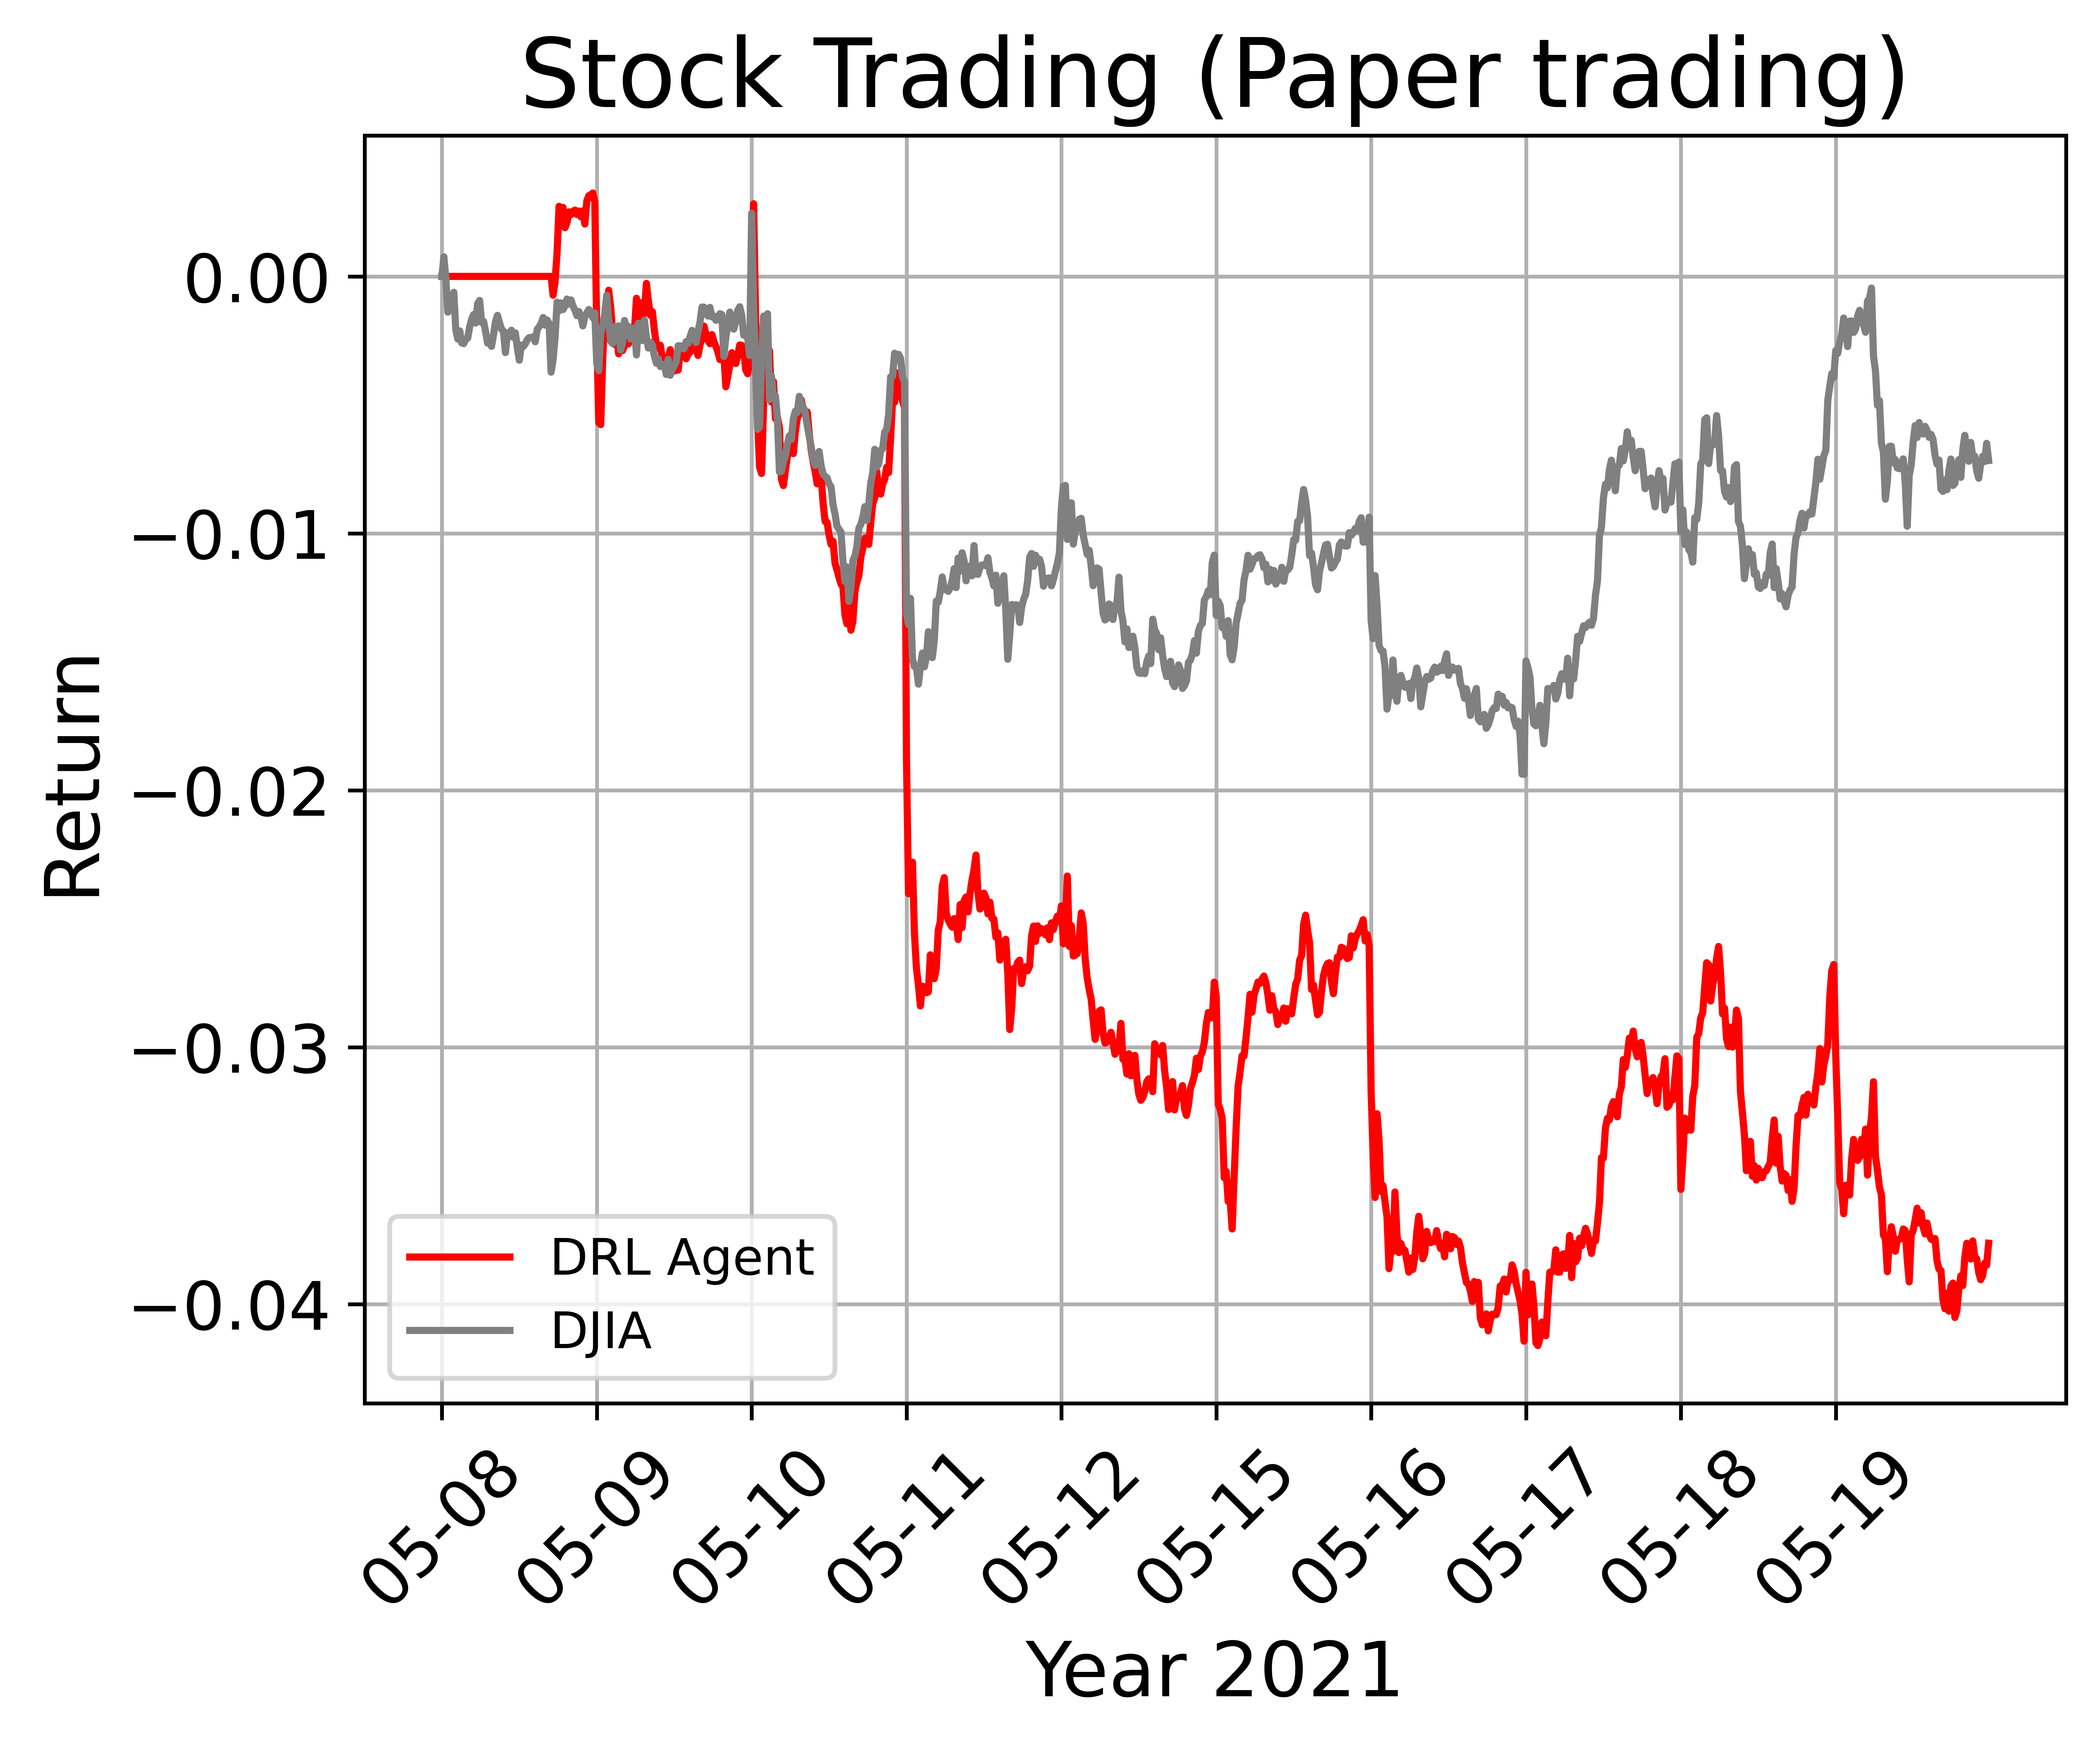

In [43]:
%matplotlib inline
plt.figure(dpi=1000)
plt.grid()
plt.grid(which='minor', axis='y')
plt.title('Stock Trading (Paper trading)', fontsize=20)
plt.plot(returns_model, label = 'DRL Agent', color = 'red')
#plt.plot(returns_sb3, label = 'Stable-Baselines3 Agent', color = 'blue' )
#plt.plot(returns_rllib, label = 'RLlib Agent', color = 'green')
plt.plot(returns_dia, label = 'DJIA', color = 'grey')
plt.ylabel('Return', fontsize=16)
plt.xlabel('Year 2021', fontsize=16)
plt.xticks(size = 14)
plt.yticks(size = 14) 
plt.xticks([0, 78, 156, 234, 312, 390, 468, 546, 624, 702], ['05-08', '05-09', '05-10', '05-11', '05-12', '05-15', '05-16', '05-17', '05-18', '05-19'],)
plt.xticks(rotation = 45)
ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(78))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(14))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.005))
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(['','05-08','','05-09','','05-10','','05-11','','05-12',
#                                                     '','05-15','','05-16','','05-17','','05-18','','05-19']))
plt.legend(fontsize=10.5)
plt.savefig('papertrading_stock.png')